# Pyma Analysis

Análisis y modelo predictivo del dataset Pima Indians Diabetes Database de Kaggle

https://www.kaggle.com/uciml/pima-indians-diabetes-database


### Importación de librerías y carga del dataset

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

import warnings

In [71]:
pima = pd.read_csv("./diabetes.csv")
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

- Pregnancies: Number of times pregnant
- Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
- BloodPressure: Diastolic blood pressure (mm Hg)
- SkinThickness: Triceps skin fold thickness (mm)
- Insulin: 2-Hour serum insulin (mu U/ml)
- BMI: Body mass index (weight in kg/(height in m)^2)
- DiabetesPedigreeFunction: Diabetes pedigree function
- Age: Age (years)

- Outcome: Class variable (0 or 1)

### Análisis del dataset

In [72]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [73]:
pima.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [74]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


En las variables "Glocose", "BloodPressure", "SkinThickness", "Insulin" y "BMI" el valor mínimo es 0, es decir, algunas de las observaciones están anotadas en estos campos como 0, lo que no es posible. Será necesario analizar los registros donde haya un valor 0 en este campo para imputar otro valor más apropiado.

De momento, cambiaremos los valores 0 de estos campos por un np.nan

In [75]:
columnas_valor_0 = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for i in columnas_valor_0:
    pima[i] = pima[i].apply(lambda x: np.nan if x==0 else x)

In [76]:
pima.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Estos datos son muy importantes: en el caso de la insulina, más de un 48% de las observaciones está mal registrada. Y hablando de diabetes, el que el valor de insulina esté mal, nos indica que este dataset no debería ser empleado para uso médico real.

Para nuestros efectos, continuaremos con el análisis, columna por columna:

#### Outcome

1 - La persona tiene diabetes
0 - No tiene

In [77]:
pima["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

Vemos que la muestra tiene un importante desequilibrio, lo que hay que tener en cuenta en el análisis y a la hora de diseñar los modelos.

#### Pregnancies

In [78]:
pd.crosstab(pima["Pregnancies"], pima["Outcome"])

Outcome,0,1
Pregnancies,,
0,73,38
1,106,29
2,84,19
3,48,27
4,45,23
5,36,21
6,34,16
7,20,25
8,16,22


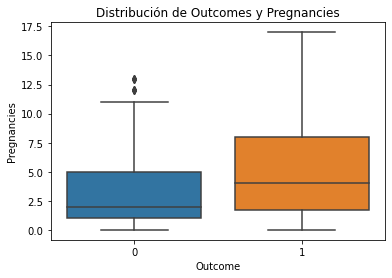

In [79]:
sns.boxplot(x="Outcome", y="Pregnancies", data=pima);
plt.title("Distribución de Outcomes y Pregnancies");

Vemos que una cierta relación que indica que a mayor número de embarazos, menores son las posibilidades de tener diabetes. Pero esto puede ser una consecuencia, más que una causa, dado que al descubrir una persona que tiene diabetes, es menos probable que quiera quedarse embarazada. O si no lo sabe, los riesgos son mayores.

#### Glucose

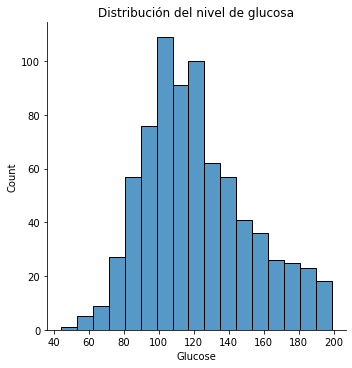

In [80]:
sns.displot(x="Glucose", data=pima);
plt.title("Distribución del nivel de glucosa");

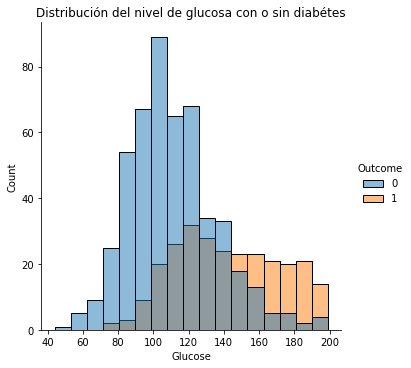

In [81]:
sns.displot(x="Glucose", hue="Outcome", data=pima);
plt.title("Distribución del nivel de glucosa con o sin diabétes");

Como era de esperar, las personas con diabetes (Outcome=1), normalmente tienen niveles de glucosa más altos que los no diabéticos. Hay que tener en cuenta que la muestra está bastante desequilibrada, por lo que este histograma puede parecernos engañoso.

#### BloodPressure

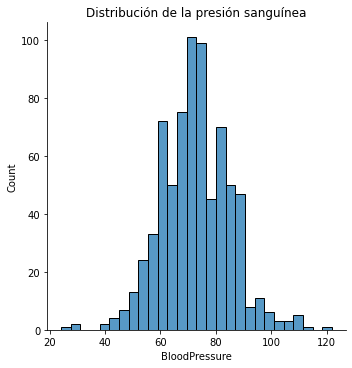

In [82]:
# Esta columna tiene algunos valores nan, pero son muy pocos, por lo que no afecta mucho a la distribución

sns.displot(x="BloodPressure", data=pima);
plt.title("Distribución de la presión sanguínea");

Vemos una distribución normal, por lo que podremos usar la media a la hora de imputar valores a los nulos.

#### SkinThickness             

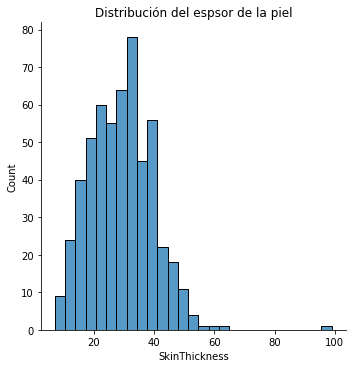

In [83]:
sns.displot(x="SkinThickness", data=pima);
plt.title("Distribución del espsor de la piel");

Esta distribución es asimétrica, por lo que será mejor usar la mediana para la asignación a los nulos

#### Insulin

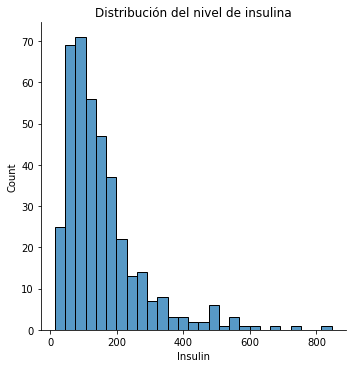

In [84]:
sns.displot(x="Insulin", data=pima);
plt.title("Distribución del nivel de insulina");

Otra distribución asimétrica, con lo que usaremos la mediana

#### BMI                          

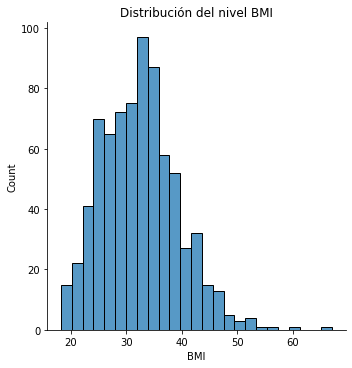

In [85]:
sns.displot(x="BMI", data=pima);
plt.title("Distribución del nivel BMI");

También asimétrica

#### DiabetesPedigreeFunction

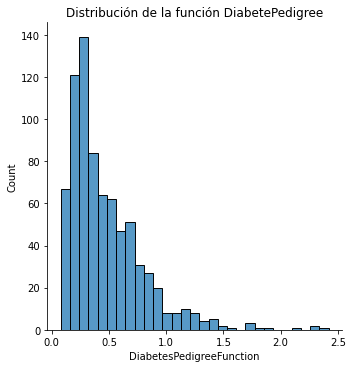

In [86]:
sns.displot(x="DiabetesPedigreeFunction", data=pima);
plt.title("Distribución de la función DiabetePedigree");

#### Age

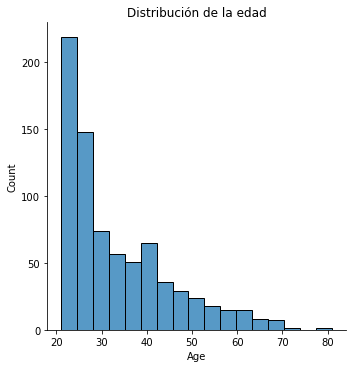

In [87]:
sns.displot(x="Age", data=pima);
plt.title("Distribución de la edad");

Aquí vemos que la muestra puede tener también un importante error de bias, dado que se trata en su mayoría de mujeres muy jóvenes.

#### Corrección de valores nulos

Vamos a usar la función SimpleImputer de sklearn para corregir los valores nulos de cada columna. Pero antes de hacerlo, tenemos que dividir el dataset en dos, una parte para el entrenamiento y otra para el test. Si aplicamos el imputer a todo el dataset, contaminaremos el set de test

In [88]:
# Primero separamos la variable dependiente
X = pima.drop("Outcome", axis=1)
y = pima["Outcome"]

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=21)

In [90]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (652, 8)
y_train shape:  (652,)
X_test shape:  (116, 8)
y_test shape:  (116,)


In [91]:
columnas_valor_0 = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
estrategia = ["mean", "mean", "median", "median", "median"]

In [92]:
warnings.filterwarnings('ignore')

for col, est in zip(columnas_valor_0, estrategia):
    imputer = SimpleImputer(strategy=est)
    X_train[col] = imputer.fit_transform(X_train[col].values.reshape(-1, 1)).copy()
    X_test[col] = imputer.transform(X_test[col].values.reshape(-1, 1)).copy()
    X[col] = imputer.transform(X[col].values.reshape(-1, 1)).copy() 
    
# El dataset total X también lo corregimos para ver el resultado final con el mejor modelo


In [93]:
X_train.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [94]:
X_test.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

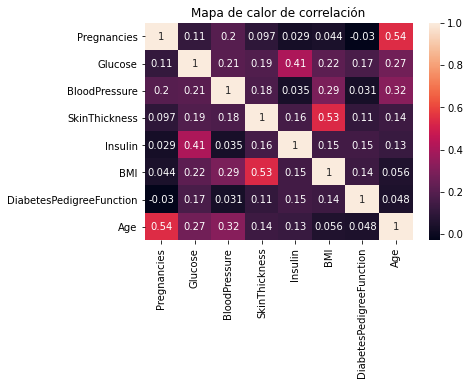

In [95]:
sns.heatmap(X_train.corr(), annot = True);
plt.title("Mapa de calor de correlación");

No hay alta correlación entre ninguna de las variables

### Definición de modelos

Probaremos con distintos tipos de modelos de Machine Learning "clásicos". El dataset es muy pequeño para que una red neuronal sea útil en este caso.

Usaremos:

- XGBoost,
- RandomForest
- Support Vector Machine
- Regresión logística
- ADA Boost

In [96]:
## Usaremos una validación cruzada para elegir el modelo más prometedor

modelos = {
    "xgboost": XGBClassifier(eval_metric="logloss"),
    "random_forest": RandomForestClassifier(random_state = 21),
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "ada_boost": AdaBoostClassifier(RandomForestClassifier(random_state = 21))
}

for modelo in modelos:
    print(f"Modelo: {modelo}")
    print("Puntuación de Validación Cruzada:")
    cv_scores = cross_val_score(make_pipeline(StandardScaler(), modelos[modelo]), X_train, y_train, cv = 5)
    print(f"Puntuación Min: {min(cv_scores)}")
    print(f"Puntuación Max: {max(cv_scores)}")    
    print(f"Puntuación Media: {np.mean(cv_scores)}")
    print()

Modelo: xgboost
Puntuación de Validación Cruzada:
Puntuación Min: 0.7022900763358778
Puntuación Max: 0.8
Puntuación Media: 0.7438990017615972

Modelo: random_forest
Puntuación de Validación Cruzada:
Puntuación Min: 0.7307692307692307
Puntuación Max: 0.8
Puntuación Media: 0.7592836171462126

Modelo: svm
Puntuación de Validación Cruzada:
Puntuación Min: 0.7
Puntuación Max: 0.7923076923076923
Puntuación Media: 0.7531062830299471

Modelo: logistic_regression
Puntuación de Validación Cruzada:
Puntuación Min: 0.7175572519083969
Puntuación Max: 0.8307692307692308
Puntuación Media: 0.7700176159718144

Modelo: ada_boost
Puntuación de Validación Cruzada:
Puntuación Min: 0.7175572519083969
Puntuación Max: 0.8076923076923077
Puntuación Media: 0.7577451556077511



Dado que la mayor puntuación la obtiene la regresión logística, ada y random forest, por lo que emplearemos estos modelos.

Pero antes de seguir, vamos a tratar el desequilibrio del dataset en lo relativo a la variable dependiente: Hay muchos más valores con valor 0 (sin diabetes, aproximadamente 2/3 de la muestra) que 1 (con diabetes, el 1/3 restante).

Para corregir este desequilibrio, usaremos SMOTE (Synthetic Minority Over-sampling Technique). Esta técnica crea datos sintéticos de las observacines infrarepresentadas en el dataset.

In [97]:
sampling = SMOTE()
X_train, y_train = sampling.fit_resample(X_train, y_train)

In [98]:
y_train.value_counts()

0    425
1    425
Name: Outcome, dtype: int64

Modelo: RandomForestClassifier(random_state=21)
Accuracy (test): 74.13793103448276%
Precision: 0.6666666666666666
Recall: 0.5365853658536586
F1: 0.5945945945945946

Modelo: LogisticRegression()
Accuracy (test): 74.13793103448276%
Precision: 0.6341463414634146
Recall: 0.6341463414634146
F1: 0.6341463414634146

Modelo: AdaBoostClassifier(base_estimator=RandomForestClassifier(random_state=21))
Accuracy (test): 70.6896551724138%
Precision: 0.6060606060606061
Recall: 0.4878048780487805
F1: 0.5405405405405406



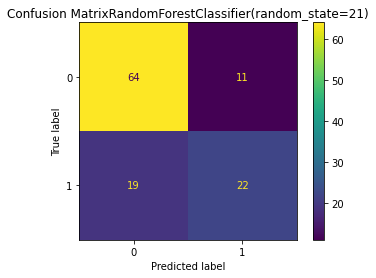

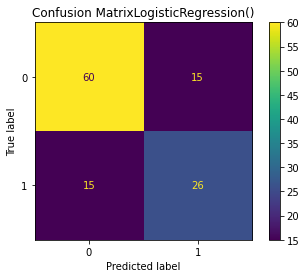

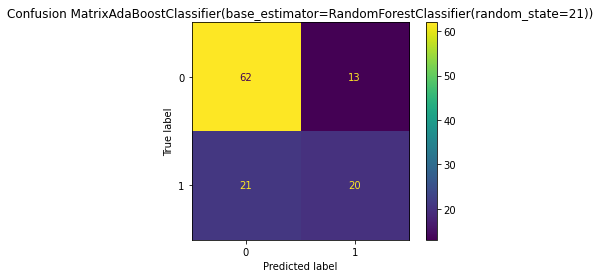

In [99]:
modelos = [
    RandomForestClassifier(random_state = 21),
    LogisticRegression(),
    AdaBoostClassifier(RandomForestClassifier(random_state = 21))
]

for modelo in modelos:
    print("Modelo:", modelo)
    pipeline = make_pipeline(StandardScaler(), modelo)
    pipeline.fit(X_train, y_train)

    predictions = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy (test): {accuracy*100}%")
    print(f"Precision: {precision_score(y_test, predictions)}")
    print(f"Recall: {recall_score(y_test, predictions)}")
    print(f"F1: {f1_score(y_test, predictions)}")
    plot_confusion_matrix(pipeline, X_test, y_test)
    title = "Confusion Matrix" + str(modelo)
    plt.title(title)
    print()



En este caso, los mejores resultados los sigue obteniendo la regresión logística. La matriz de confusión también es la mejor, dado que el peor error (predecir el no tener diabetes cuando la realizada es que si es el peor de los casos posibles).

Por tanto, en producción usaríamos una regresión logística. Vemos los valores definitivos conseguidos con todo el dataset original:

Modelo de Regresión Logística con todos los datos:
Accuracy (test): 95.57291666666666%
Precision: 0.95
Recall: 0.9216417910447762
F1: 0.9356060606060606


Text(0.5, 1.0, 'Confusion Matrix')

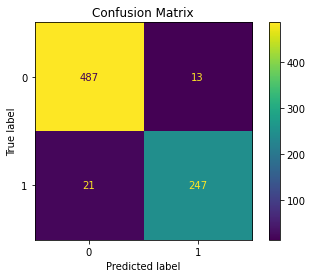

In [102]:
print("Modelo de Regresión Logística con todos los datos:" )

predictions = pipeline.predict(X.values)
accuracy = accuracy_score(y, predictions)
print(f"Accuracy (test): {accuracy*100}%")
print(f"Precision: {precision_score(y, predictions)}")
print(f"Recall: {recall_score(y, predictions)}")
print(f"F1: {f1_score(y, predictions)}")
plot_confusion_matrix(pipeline, X.values, y);
title = "Confusion Matrix"
plt.title(title)